In [2]:
%config Completer.use_jedi = False

In [3]:
cd models

/Users/cmougan/Desktop/Novartis2021/models


In [4]:
import shap

In [5]:
# %% Imports
import pandas as pd
import sys
import numpy as np

sys.path.append("../")
from metrics.metric_participants import ComputeMetrics, print_metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sktools import IsEmptyExtractor
from lightgbm import LGBMRegressor
from category_encoders import OneHotEncoder
from sktools import QuantileEncoder
from category_encoders import TargetEncoder
from sklearn.linear_model import QuantileRegressor
from sklego.preprocessing import ColumnSelector
from sklearn.preprocessing import StandardScaler
import random
from tools.postprocessing import clip_first_month

from eda.checker import check_train_test
from tools.postprocessing import postprocess_predictions

random.seed(0)

sales_train = pd.read_csv("../data/data_raw/sales_train.csv")
df_full = pd.read_csv("../data/split.csv")
df_region = pd.read_csv("../data/data_raw/regions.csv")
regions_hcps = pd.read_csv("../data/data_raw/regions_hcps.csv")
activity_features = pd.read_csv("../data/features/activity_features.csv")
brands_3_12 = pd.read_csv("../data/features/brand_3_12_market_features_lagged.csv")
rte_basic = pd.read_csv("../data/features/rte_basic_features.csv").drop(
    columns=["sales", "validation"]
)

market_size = pd.read_csv("../data/market_size.csv")

# For reproducibility
random.seed(0)
VAL_SIZE = 38
SUBMISSION_NAME = "linear_model_feat_plus"
RETRAIN = True

# %% Training weights
market_size = market_size.assign(weight=lambda x: 100 / x["sales"]).rename(
    columns={"sales": "market_size"}
)

market_size

# %% Add region data
df_feats = df_full.merge(df_region, on="region", how="left")
df_feats = pd.merge(left=df_feats, right=regions_hcps, how="left", on="region")
df_feats = df_feats.merge(
    activity_features, on=["month", "region", "brand"], how="left"
)
df_feats = df_feats.merge(rte_basic, on=["month", "region", "brand"], how="left")
df_feats = df_feats.merge(brands_3_12, on=["month", "region"], how="left")
df_feats["whichBrand"] = np.where(df_feats.brand == "brand_1", 1, 0)

df_feats = df_feats.merge(market_size, on="region", how="left")

df_feats["month_brand"] = df_feats.month + "_" + df_feats.brand


df_feats["market_estimation"] = (
    df_feats.sales_brand_12_market * df_feats.sales_brand_3
) / df_feats.sales_brand_3_market

df_feats.loc[df_feats.brand == "brand_1", "market_estimation"] = (
    0.75 * df_feats.loc[df_feats.brand == "brand_1", "market_estimation"]
)
df_feats.loc[df_feats.brand == "brand_2", "market_estimation"] = (
    0.25 * df_feats.loc[df_feats.brand == "brand_2", "market_estimation"]
)
# drop sum variables
cols_to_drop = ["region", "sales", "validation", "market_size", "weight"]

# %% Split train val test
X_train = df_feats.query("validation == 0").drop(columns=cols_to_drop)
y_train = df_feats.query("validation == 0").sales
weights_train = df_feats.query("validation == 0").weight

X_val = df_feats.query("validation == 1").drop(columns=cols_to_drop)
y_val = df_feats.query("validation == 1").sales

X_full = df_feats.query("validation.notnull()", engine="python").drop(
    columns=cols_to_drop
)
y_full = df_feats.query("validation.notnull()", engine="python").sales
weights_full = df_feats.query("validation.notnull()", engine="python").weight

X_test = df_feats.query("validation.isnull()", engine="python").drop(
    columns=cols_to_drop
)
y_test = df_feats.query("validation.isnull()", engine="python").sales

check_train_test(X_train, X_val)
check_train_test(X_train, X_test, threshold=0.3)
check_train_test(X_val, X_test)
# %%
feats = {}
feats[0.5] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
    "market_estimation",
]
feats[0.1] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "count_f2f",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
    "market_estimation",
]
feats[0.9] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "tier_openings_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
    "market_estimation",
]

encoder = {}
encoder[0.1] = QuantileEncoder(cols=["month_brand"], quantile=0.2)
encoder[0.5] = TargetEncoder(cols=["month_brand"])
encoder[0.9] = QuantileEncoder(cols=["month_brand"], quantile=0.8)
# %%
models = {}
pipes = {}
train_preds = {}
val_preds = {}
test_preds = {}

for quantile in [0.5, 0.1, 0.9]:

    print("Quantile:", quantile)
    models[quantile] = QuantileRegressor(quantile=quantile, alpha=0, solver="highs-ds")

    pipes[quantile] = Pipeline(
        [
            ("ohe", OneHotEncoder(cols=["month"])),
            ("te", encoder[quantile]),
            ("selector", ColumnSelector(columns=feats[quantile])),
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scale", StandardScaler()),
            ("qr", models[quantile]),
        ]
    )

    # Fit cv model
    pipes[quantile].fit(X_train, y_train)
    # , qr__sample_weight=weights_train)

    train_preds[quantile] = pipes[quantile].predict(X_train)
    val_preds[quantile] = pipes[quantile].predict(X_val)

    if RETRAIN:
        pipes[quantile].fit(X_full, y_full)
        # , qr__sample_weight=weights_full)
    test_preds[quantile] = pipes[quantile].predict(X_test)

# %% Postprocess
train_preds_post = postprocess_predictions(train_preds)
val_preds_post = postprocess_predictions(val_preds)
test_preds_post = postprocess_predictions(test_preds)

# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds_post[0.5])
    .assign(lower=train_preds_post[0.1])
    .assign(upper=train_preds_post[0.9])
    .pipe(clip_first_month)
)

ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print_metrics(train_preds_df, sales_train, ground_truth_train)

# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds_post[0.5])
    .assign(lower=val_preds_post[0.1])
    .assign(upper=val_preds_post[0.9])
    .pipe(clip_first_month)
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]

print_metrics(val_preds_df, sales_train, ground_truth_val)

# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}_val.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds_post[0.5])
    .assign(lower=test_preds_post[0.1])
    .assign(upper=test_preds_post[0.9])
    .pipe(clip_first_month)
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


Quantile: 0.5
Quantile: 0.1
Quantile: 0.9
Accuracy: 50.79, interval: 177.10
Accuracy: 31.72, interval: 145.74


In [11]:
tr = df_feats[(df_feats.validation == 1) | (df_feats.validation == 0)]

In [21]:
te = df_feats.query("validation.isnull()", engine="python")

In [24]:
te['market_estimation'].values

array([13033.73486589,  4344.57828863, 12539.45436535, ...,
        5283.34087304, 21484.46224486,  7161.48741495])

In [25]:
tr['market_estimation'].values

array([22782.40408836,  7594.13469612, 20862.6424162 , ...,
        5536.33671313, 34116.74851338, 11372.24950446])

In [26]:
from scipy.stats import ks_2samp, entropy, kruskal

In [27]:
ks_2samp(tr['market_estimation'].values, te['market_estimation'].values).statistic

0.057261116367076634

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

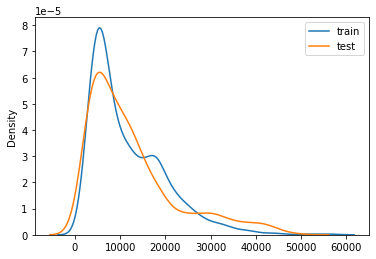

In [36]:
plt.figure()
sns.kdeplot(tr['market_estimation'].values,label='train')
sns.kdeplot(te['market_estimation'].values,label='test')
plt.legend()
plt.show()

In [5]:
    'whichBrand',
    'count',
    'inverse_tier_f2f',
    'hcp_distinct_Internal medicine / pneumology',
    'sales_brand_3',
    'sales_brand_3_market',
    'sales_brand_12_market',
    'month_brand',
    'month',
    'brand'

'brand'

In [6]:
feats = {}
feats[0.5] = [
    'whichBrand',
    "sales_brand_12_marketshift0",
    "sales_brand_3",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "month_brand",
    "null_tiers_phone",
    "null_tiers",
    "Pediatrician",
    "sales_brand_3_marketshift-4",
    "sales_brand_3shift-10",
    "hcp_distinct_Internal medicine / pneumology_3m",
    "Internal medicine and general practicioner",
    "count",
    "inverse_tier_Pediatrician",
    "sales_brand_12_marketshift4",
    "no. clicks",
    "no. openings_Internal medicine / pneumology",
    "hcp_distinct",
]
feats[0.1] = [
    'whichBrand',
    "month",
    "count",
    "month_brand",
    "count_f2f",
    "sales_brand_12_marketshift0",
    "inverse_tier_f2f",
    "sales_brand_3_market_per_region",
    "sales_brand_3",
    "sales_brand_3_marketshift0",
]
feats[0.9] = [
    'whichBrand',
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_12_marketshift0",
    "month_brand",
    "tier_openings_Internal medicine / pneumology",
    "hcp_distinct_Internal medicine / pneumology_3m",
    "no. openings_Pediatrician",
    "inverse_tier_Pediatrician",
    "no. openings_Internal medicine / pneumology",
    "no. clicks_Internal medicine",
    "hcp_distinct",
    "no. clicks_product_related",
]

In [21]:
feats = {}
feats[0.5] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
    'market_estimation'
]
feats[0.1] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "count_f2f",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
    'market_estimation'
]
feats[0.9] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "tier_openings_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
    'market_estimation'
]

encoder = {}
encoder[0.1] = QuantileEncoder(cols=["month_brand"],quantile=0.2)
encoder[0.5] = TargetEncoder(cols=["month_brand"])
encoder[0.9] = QuantileEncoder(cols=["month_brand"],quantile=0.8)

In [23]:

# %%
models = {}
pipes = {}
train_preds = {}
val_preds = {}
test_preds = {}

for quantile in [0.5, 0.1, 0.9]:

    print("Quantile:", quantile)
    models[quantile] = QuantileRegressor(
        quantile=quantile,
        alpha=0,
        solver="highs-ds"
    )

    pipes[quantile] = Pipeline(
        [   ('ohe',OneHotEncoder(cols = ['month'])),
            ("te",encoder[quantile]),
            ("selector", ColumnSelector(columns=feats[quantile])),
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)), 
            ("scale", StandardScaler()),
            ("qr", models[quantile])
        ]
    )

    # Fit cv model
    pipes[quantile].fit(X_train, y_train)
    # , qr__sample_weight=weights_train)

    train_preds[quantile] = pipes[quantile].predict(X_train)
    val_preds[quantile] = pipes[quantile].predict(X_val)

    if RETRAIN:
        pipes[quantile].fit(X_full, y_full)
        # , qr__sample_weight=weights_full)
    test_preds[quantile] = pipes[quantile].predict(X_test)


Quantile: 0.5
Quantile: 0.1
Quantile: 0.9


In [24]:
# %% Postprocess
train_preds_post = postprocess_predictions(train_preds)
val_preds_post = postprocess_predictions(val_preds)
test_preds_post = postprocess_predictions(test_preds)

# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds_post[0.5])
    .assign(lower=train_preds_post[0.1])
    .assign(upper=train_preds_post[0.9])
)

ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print_metrics(train_preds_df, sales_train, ground_truth_train)

# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds_post[0.5])
    .assign(lower=val_preds_post[0.1])
    .assign(upper=val_preds_post[0.9])
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]


# %%


print_metrics(val_preds_df, sales_train, ground_truth_val)

Accuracy: 51.58, interval: 179.15
Accuracy: 32.56, interval: 147.80


(32.55885252772722, 147.80258792681033)

In [ ]:
Best
32.55, 147.80
Original
34.31, 152.87

In [ ]:
Feats, OHE, Month, QE

In [ ]:

# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}_val.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds_post[0.5])
    .assign(lower=test_preds_post[0.1])
    .assign(upper=test_preds_post[0.9])
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


In [ ]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(pipes[0.5].named_steps["lgb"])
shap_values = explainer(
    pd.DataFrame(pipe[:-1].transform(X_train), columns=X_train.columns)
)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
X_train.columns

In [ ]:
# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds[0.5])
    .assign(lower=train_preds[0.1].clip(0))
    .assign(upper=train_preds[0.9])
)

ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(train_preds_df, sales_train, ground_truth_train))

# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds[0.5])
    .assign(lower=val_preds[0.1].clip(0))
    .assign(upper=val_preds[0.9])
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(val_preds_df, sales_train, ground_truth_val))

# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds[0.5])
    .assign(lower=test_preds[0.1].clip(0))
    .assign(upper=test_preds[0.9])
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


# %%

# %%

In [25]:
# %% Imports
import pandas as pd
import sys
import numpy as np

sys.path.append("../")
from metrics.metric_participants import ComputeMetrics, print_metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sktools import IsEmptyExtractor
from lightgbm import LGBMRegressor
from category_encoders import OneHotEncoder
from sktools import QuantileEncoder
from category_encoders import TargetEncoder
from sklearn.linear_model import QuantileRegressor
from sklego.preprocessing import ColumnSelector
from sklearn.preprocessing import StandardScaler
import random
from tools.postprocessing import clip_first_month

from eda.checker import check_train_test
from tools.postprocessing import postprocess_predictions

random.seed(0)

sales_train = pd.read_csv("../data/data_raw/sales_train.csv")
df_full = pd.read_csv("../data/split.csv")
df_region = pd.read_csv("../data/data_raw/regions.csv")
regions_hcps = pd.read_csv("../data/data_raw/regions_hcps.csv")
activity_features = pd.read_csv("../data/features/activity_features.csv")
brands_3_12 = pd.read_csv("../data/features/brand_3_12_market_features_lagged.csv")
rte_basic = pd.read_csv("../data/features/rte_basic_features.csv").drop(
    columns=["sales", "validation"]
)

market_size = pd.read_csv("../data/market_size.csv")

# For reproducibility
random.seed(0)
VAL_SIZE = 38
SUBMISSION_NAME = "linear_model_simple"
RETRAIN = True

# %% Training weights
market_size = market_size.assign(weight=lambda x: 100 / x["sales"]).rename(
    columns={"sales": "market_size"}
)

market_size

# %% Add region data
df_feats = df_full.merge(df_region, on="region", how="left")
df_feats = pd.merge(left=df_feats, right=regions_hcps, how="left", on="region")
df_feats = df_feats.merge(
    activity_features, on=["month", "region", "brand"], how="left"
)
df_feats = df_feats.merge(rte_basic, on=["month", "region", "brand"], how="left")
df_feats = df_feats.merge(brands_3_12, on=["month", "region"], how="left")
df_feats["whichBrand"] = np.where(df_feats.brand == "brand_1", 1, 0)

df_feats = df_feats.merge(market_size, on="region", how="left")

df_feats["month_brand"] = df_feats.month + "_" + df_feats.brand

# drop sum variables
cols_to_drop = ["region", "sales", "validation", "market_size", "weight"]

# %% Split train val test
X_train = df_feats.query("validation == 0").drop(columns=cols_to_drop)
y_train = df_feats.query("validation == 0").sales
weights_train = df_feats.query("validation == 0").weight

X_val = df_feats.query("validation == 1").drop(columns=cols_to_drop)
y_val = df_feats.query("validation == 1").sales

X_full = df_feats.query("validation.notnull()", engine="python").drop(
    columns=cols_to_drop
)
y_full = df_feats.query("validation.notnull()", engine="python").sales
weights_full = df_feats.query("validation.notnull()", engine="python").weight

X_test = df_feats.query("validation.isnull()", engine="python").drop(
    columns=cols_to_drop
)
y_test = df_feats.query("validation.isnull()", engine="python").sales

check_train_test(X_train, X_val)
check_train_test(X_train, X_test, threshold=0.3)
check_train_test(X_val, X_test)
# %%
feats = {}
feats[0.5] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
]
feats[0.1] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "count_f2f",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
]
feats[0.9] = [
    "whichBrand",
    "count",
    "inverse_tier_f2f",
    "hcp_distinct_Internal medicine / pneumology",
    "tier_openings_Internal medicine / pneumology",
    "sales_brand_3",
    "sales_brand_3_market",
    "sales_brand_12_market",
    "month_brand",
    "month_1",
    "month_2",
    "month_3",
    "month_4",
    "month_5",
    "month_6",
    "month_7",
    "month_8",
    "month_9",
    "month_10",
    "month_11",
    "month_12",
    "month_13",
    "month_14",
]

encoder = {}
encoder[0.1] = QuantileEncoder(cols=["month_brand"], quantile=0.2)
encoder[0.5] = TargetEncoder(cols=["month_brand"])
encoder[0.9] = QuantileEncoder(cols=["month_brand"], quantile=0.8)
# %%
models = {}
pipes = {}
train_preds = {}
val_preds = {}
test_preds = {}

for quantile in [0.5, 0.1, 0.9]:

    print("Quantile:", quantile)
    models[quantile] = QuantileRegressor(quantile=quantile, alpha=0, solver="highs-ds")

    pipes[quantile] = Pipeline(
        [
            ("ohe", OneHotEncoder(cols=["month"])),
            ("te", encoder[quantile]),
            ("selector", ColumnSelector(columns=feats[quantile])),
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scale", StandardScaler()),
            ("qr", models[quantile]),
        ]
    )

    # Fit cv model
    pipes[quantile].fit(X_train, y_train)
    # , qr__sample_weight=weights_train)

    train_preds[quantile] = pipes[quantile].predict(X_train)
    val_preds[quantile] = pipes[quantile].predict(X_val)

    if RETRAIN:
        pipes[quantile].fit(X_full, y_full)
        # , qr__sample_weight=weights_full)
    test_preds[quantile] = pipes[quantile].predict(X_test)

# %% Postprocess
train_preds_post = postprocess_predictions(train_preds)
val_preds_post = postprocess_predictions(val_preds)
test_preds_post = postprocess_predictions(test_preds)

# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds_post[0.5])
    .assign(lower=train_preds_post[0.1])
    .assign(upper=train_preds_post[0.9])
    .assign(clip_first_month)
)

ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print_metrics(train_preds_df, sales_train, ground_truth_train)

# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds_post[0.5])
    .assign(lower=val_preds_post[0.1])
    .assign(upper=val_preds_post[0.9])
    .assign(clip_first_month)
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]

print_metrics(val_preds_df, sales_train, ground_truth_val)

# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}_val.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds_post[0.5])
    .assign(lower=test_preds_post[0.1])
    .assign(upper=test_preds_post[0.9])
    .assign(clip_first_month)
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


Quantile: 0.5
Quantile: 0.1


KeyboardInterrupt: 